Take the sos netcdfs, add a bunch of useful variables, save as a tidy dataset.

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import datetime as dt

from sublimpy import variables
from sublimpy import utils
from sublimpy import tidy

import matplotlib.pyplot as plt

import altair as alt
alt.data_transformers.enable('json')

from metpy.calc import specific_humidity_from_mixing_ratio
from metpy.units import units
import metpy.constants
import pint_pandas
import pint_xarray
import xarray as xr
import os

In [2]:
example_ds = xr.open_dataset("/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_qc_geo_tiltcor_v20240307/isfs_sos_qc_geo_tiltcor_5min_20230122.nc")

# Inputs

In [3]:
sos_data_dir = '/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_qc_geo_tiltcor_v20240307/'
DATE_FORMAT_STR = '%Y%m%d'
start_date = '20221130'
end_date = '20230509'
PLANAR_FIT = False

datelist = pd.date_range(
    dt.datetime.strptime(start_date, DATE_FORMAT_STR),
    dt.datetime.strptime(end_date, DATE_FORMAT_STR),
    freq='d'
).strftime(DATE_FORMAT_STR).tolist()

In [4]:
# Separate out the eddy covariance measurement variable names because they are very repetitive
ec_measurement_suffixes = [
    '1m_ue',    '2m_ue',    '3m_ue',    '10m_ue', 
    '1m_d',     '2m_d',     '3m_d',     '10m_d',
    '1m_uw',    '2m_uw',    '2_5m_uw',  '3m_uw',    '10m_uw', 
    '1m_c',     '2m_c',     '3m_c',     '5m_c',     '10m_c',    '15m_c',    '20m_c'
]

sonic_measurement_prefixes = [
    'u_', 'v_', 'w_', 'tc_', 'spd_', 'dir_', 
    'u_u__', 'v_v__', 'w_w__', 'tc_tc__', 
    'u_w__', 'v_w__', 'u_v__', 
    'u_tc__', 'v_tc__', 'w_tc__', 
    'u_u_u__', 'v_v_v__', 'w_w_w__', 
    'tc_tc_tc__', 
]
irga_measurement_prefixes = [
    'h2o_', 'h2o_h2o__', 'h2o_h2o_h2o__', 
]
sonic_plus_irga_measurement_prefixes = [
    'u_h2o__', 'v_h2o__', 'w_h2o__', 
]
ec_measurement_prefixes = sonic_measurement_prefixes + irga_measurement_prefixes + sonic_plus_irga_measurement_prefixes

ec_variable_names = [
    (prefix + suffix) for prefix in ec_measurement_prefixes for suffix in ec_measurement_suffixes
]

counts_vars = ['counts_' + suffix for suffix in ec_measurement_suffixes]
counts_1_vars = ['counts_' + suffix + '_1' for suffix in ec_measurement_suffixes]
counts_2_vars = ['counts_' + suffix + '_2' for suffix in ec_measurement_suffixes]
irgadiag_vars = ['irgadiag_' + suffix for suffix in ec_measurement_suffixes]
ldiag_vars = ['ldiag_' + suffix for suffix in ec_measurement_suffixes]

diagnostic_variable_names = counts_vars + counts_1_vars + counts_2_vars + irgadiag_vars + ldiag_vars

VARIABLE_NAMES = ec_variable_names + diagnostic_variable_names + [
    # Temperature & Relative Humidity Array 
    'T_1m_c', 'T_2m_c', 'T_3m_c', 'T_4m_c', 'T_5m_c', 'T_6m_c', 'T_7m_c', 'T_8m_c', 'T_9m_c', 'T_10m_c',
    'T_11m_c', 'T_12m_c', 'T_13m_c', 'T_14m_c', 'T_15m_c', 'T_16m_c', 'T_17m_c', 'T_18m_c', 'T_19m_c', 'T_20m_c',

    'RH_1m_c', 'RH_2m_c', 'RH_3m_c', 'RH_4m_c', 'RH_5m_c', 'RH_6m_c', 'RH_7m_c', 'RH_8m_c', 'RH_9m_c', 'RH_10m_c',
    'RH_11m_c','RH_12m_c','RH_13m_c','RH_14m_c','RH_15m_c','RH_16m_c','RH_17m_c','RH_18m_c','RH_19m_c','RH_20m_c',

    # Pressure Sensors
    'P_20m_c',
    'P_10m_c', 'P_10m_d', 'P_10m_uw', 'P_10m_ue',

    # Blowing snow/FlowCapt Sensors
    'SF_avg_1m_ue', 'SF_avg_2m_ue',

    # Apogee sensors
    "Vtherm_c", "Vtherm_d", "Vtherm_ue", "Vtherm_uw", 
    "Vpile_c", "Vpile_d", "Vpile_ue", "Vpile_uw",
    "IDir_c", "IDir_d", "IDir_ue", "IDir_uw",

    # Snow-level temperature arrays (towers D and UW)
    'Tsnow_0_4m_d', 'Tsnow_0_5m_d', 'Tsnow_0_6m_d', 'Tsnow_0_7m_d', 'Tsnow_0_8m_d', 'Tsnow_0_9m_d', 'Tsnow_1_0m_d', 'Tsnow_1_1m_d', 'Tsnow_1_2m_d', 'Tsnow_1_3m_d', 'Tsnow_1_4m_d', 'Tsnow_1_5m_d',
    'Tsnow_0_4m_uw', 'Tsnow_0_5m_uw', 'Tsnow_0_6m_uw', 'Tsnow_0_7m_uw', 'Tsnow_0_8m_uw', 'Tsnow_0_9m_uw', 'Tsnow_1_0m_uw', 'Tsnow_1_1m_uw', 'Tsnow_1_2m_uw', 'Tsnow_1_3m_uw', 'Tsnow_1_4m_uw', 'Tsnow_1_5m_uw',
    
    # Downward/Upward Facing Longwave Radiometers
    'Rpile_out_9m_d','Tcase_out_9m_d',    
    'Rpile_in_9m_d', 'Tcase_in_9m_d',
    'Tcase_uw', 'Rpile_in_uw', 'Rpile_out_uw',
    
    # Upward facing shortwave radiometer (tower D) - for measuring incoming solar radiation!
    'Rsw_in_9m_d', 'Rsw_out_9m_d',

    # Snow Pillow SWE
    'SWE_p1_c', 'SWE_p2_c', 'SWE_p3_c', 'SWE_p4_c',

    # Soil Moisture
    'Qsoil_d',
]

# Open and concatenate daily SoS datasets

In [ ]:
# sos_ds = utils.download_sos_data(start_date, end_date, VARIABLE_NAMES, sos_download_dir, cache=True, planar_fit=False)

all_file_paths = [
    os.path.join(
        sos_data_dir,
        f'isfs_sos_qc_geo_tiltcor_5min_{date}.nc'
    ) for date in datelist
]
datasets = []
for file in all_file_paths:
    ds = xr.open_dataset(file)
    # this ensures we don't access variables that aren't in this dataset, which would throw an error
    ds_new = ds[set(ds.data_vars).intersection(VARIABLE_NAMES)]
    datasets.append(ds_new)

In [ ]:
sos_ds = xr.concat(datasets, dim='time')

Ensure time index is evenly spaced by filling in any missing timestamps

In [ ]:
sos_ds = utils.fill_missing_timestamps(sos_ds)

In [ ]:
sos_ds.to_netcdf("sos_ds_temp_storage.cdf")

In [5]:
sos_ds = xr.open_dataset("sos_ds_temp_storage.cdf")

# Apply "minimum quality criteria" for data (Stiperski and Rotach, 2016)

Based on Stiperski and Rotach (2016, http://link.springer.com/10.1007/s10546-015-0103-z), who recommend the following steps as minimum quality criteria:

1. The sonic diagnostic flag was set high (malfunctioning of the instrument) inside the averaging period. 
2. KH20 voltage fell below 5 mV (indication of condensation occurring on the KH20 window).
3. Skewness of temperature and wind components fell outside the [-2, 2] range, following Vickers and Mahrt (1997).
4. Kurtosis of temperature and wind components was >8, following Vickers and Mahrt (1997).

We only implement number #2 and #3. We tried implementing #1, using the ldiag flag to remove sonic data, but it removed a lot of data, and, without using high rate data, we't cannot filter based on a "high" diagnostic flag, we can only filtering using the aggregate of all the flags (i.e. ldiag > 0). The 4th moments are not included in the 5-minute averages, so we cannot implement #4 without using the high rate data.

## Set bad Irga measurements to NaN

The NCAR report recommends all Irga-related measurements be set to NaN when irgadiag is non-zero.  They did this for some but not all of the data.

In [6]:
print('h2o_flux_var', 'irgadiag_var', 'old_nan_count', 'new_nan_count', 'old_mean', 'new_mean')
var_ls = []
old_nan_count_ls = []
new_nan_count_ls = []
old_mean_ls = []
new_mean_ls = []
old_median_ls = []
new_median_ls = []
for suffix in ec_measurement_suffixes:
    h2o_flux_var = 'w_h2o__' + suffix
    irgadiag_var = 'irgadiag_' + suffix
     
    old_nan_count = (np.isnan(sos_ds[h2o_flux_var])).sum().item()
    old_mean = sos_ds[h2o_flux_var].mean().item()
    old_median = sos_ds[h2o_flux_var].median().item()

    for prefix in [
        'h2o_', 'h2o_h2o__', 'u_h2o__', 'v_h2o__', 'w_h2o__',
        # I'M NOT SURE I WANT TO REMOVE THESE w_ MEASUREMENTS BUT I"M CURIOUS WHAT HAPPENS IF I DO
        'w_',
    ]:
        sos_ds[prefix+suffix] = sos_ds[prefix+suffix].where(sos_ds[irgadiag_var] == 0)
    
    new_nan_count = (np.isnan(sos_ds[h2o_flux_var])).sum().item()
    new_mean = sos_ds[h2o_flux_var].mean().item()
    new_median = sos_ds[h2o_flux_var].median().item()
    print(h2o_flux_var, irgadiag_var, old_nan_count, new_nan_count, round(old_mean,6), round(new_mean,6))
    var_ls.append(h2o_flux_var)
    old_nan_count_ls.append(old_nan_count)
    new_nan_count_ls.append(new_nan_count)
    old_mean_ls.append(old_mean)
    new_mean_ls.append(new_mean)
    old_median_ls.append(old_median)
    new_median_ls.append(new_median)

h2o_flux_var irgadiag_var old_nan_count new_nan_count old_mean new_mean
w_h2o__1m_ue irgadiag_1m_ue 37308 37854 0.001172 0.001041
w_h2o__2m_ue irgadiag_2m_ue 18878 20470 0.002759 0.002856
w_h2o__3m_ue irgadiag_3m_ue 5434 6319 0.002864 0.002866
w_h2o__10m_ue irgadiag_10m_ue 5110 8715 0.002509 0.002579
w_h2o__1m_d irgadiag_1m_d 36478 37206 0.001107 0.000949
w_h2o__2m_d irgadiag_2m_d 20317 21930 0.002174 0.002284
w_h2o__3m_d irgadiag_3m_d 5669 7912 0.002803 0.002872
w_h2o__10m_d irgadiag_10m_d 5651 7819 0.002705 0.002787
w_h2o__1m_uw irgadiag_1m_uw 40835 41246 0.001176 0.000965
w_h2o__2m_uw irgadiag_2m_uw 26281 27714 0.002208 0.002308
w_h2o__2_5m_uw irgadiag_2_5m_uw 37809 38482 0.00223 0.002422
w_h2o__3m_uw irgadiag_3m_uw 4945 5813 0.002789 0.002817
w_h2o__10m_uw irgadiag_10m_uw 5512 7816 0.002821 0.002848
w_h2o__1m_c irgadiag_1m_c 28299 29245 0.001533 0.001513
w_h2o__2m_c irgadiag_2m_c 3862 6667 0.002465 0.002529
w_h2o__3m_c irgadiag_3m_c 3947 6503 0.002732 0.002787
w_h2o__5m_c irgadiag_

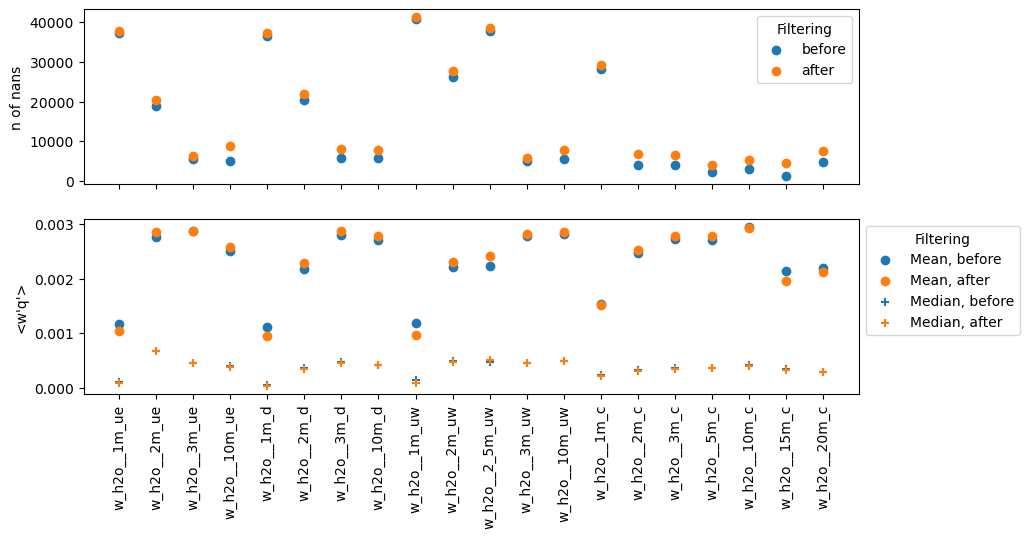

In [7]:
fig, axes = plt.subplots(2,1, sharex=True, figsize=(10,5))
axes[0].scatter(var_ls, old_nan_count_ls, label = 'before', color='tab:blue')
axes[0].set_ylabel("n of nans")
axes[0].scatter(var_ls, new_nan_count_ls, label = 'after', color='tab:orange')

axes[1].scatter(var_ls, old_mean_ls, label = 'Mean, before', color='tab:blue')
axes[1].set_ylabel("<w'q'>")
axes[1].scatter(var_ls, new_mean_ls, label = 'Mean, after', color='tab:orange')

axes[1].scatter(var_ls, old_median_ls, label = 'Median, before', marker='+', color='tab:blue')
axes[1].set_ylabel("<w'q'>")
axes[1].scatter(var_ls, new_median_ls, label = 'Median, after', marker='+', color='tab:orange')

for ax in axes:
    ax.tick_params(rotation=90, axis='x')
    ax.legend(title='Filtering', bbox_to_anchor=(1,1))

## Set bad Sonic measurements to Nan

In [8]:
# print('h2o_flux_var', 'ldiag_var', 'old_nan_count', 'new_nan_count', 'old_mean', 'new_mean')

# var_ls = []
# old_nan_count_ls = []
# new_nan_count_ls = []
# old_mean_ls = []
# new_mean_ls = []
# for suffix in [
#     '1m_uw','3m_uw', '10m_uw', 
#     '1m_ue', '3m_ue', '10m_ue', 
#     '1m_d', '3m_d', '10m_d', 
#     '2m_c', '3m_c', '5m_c', '10m_c', '15m_c', 
#     '20m_c',
# ]:
#     w_var = 'w_' + suffix
#     h2o_flux_var = 'w_h2o__' + suffix
#     sonicdiag_var = 'ldiag_' + suffix
#     old_nan_count = (np.isnan(sos_ds[h2o_flux_var])).sum().item()
#     old_mean = sos_ds[h2o_flux_var].mean().item()
#     sos_ds[h2o_flux_var] = sos_ds[h2o_flux_var].where(sos_ds[sonicdiag_var] == 0)
#     sos_ds[w_var] = sos_ds[w_var].where(sos_ds[sonicdiag_var] == 0)
#     new_nan_count = (np.isnan(sos_ds[h2o_flux_var])).sum().item()
#     new_mean = sos_ds[h2o_flux_var].mean().item()
#     print(h2o_flux_var, sonicdiag_var, old_nan_count, new_nan_count, round(old_mean,6), round(new_mean,6))
#     var_ls.append(h2o_flux_var)
#     old_nan_count_ls.append(old_nan_count)
#     new_nan_count_ls.append(new_nan_count)
#     old_mean_ls.append(old_mean)
#     new_mean_ls.append(new_mean)

In [9]:
# fig, axes = plt.subplots(2,1, sharex=True, figsize=(10,5))
# axes[0].scatter(var_ls, old_nan_count_ls, label = 'Before')
# axes[0].set_ylabel("n of nans")
# axes[0].scatter(var_ls, new_nan_count_ls, label = 'After')

# axes[1].scatter(var_ls, old_mean_ls, label = 'Before')
# axes[1].set_ylabel("<w'q'>")
# axes[1].scatter(var_ls, new_mean_ls, label = 'After')

# for ax in axes:
#     ax.tick_params(rotation=45)
#     ax.legend(title='Filtering')

## Remove data points when skewness of temperature and wind components is outside range [-2,2] (Vickers and Mahrt, 1997)

In [10]:
print('h2o_flux_var', 'old_nan_count', 'new_nan_count')
var_ls = []
old_nan_count_ls = []
new_nan_count_ls = []
old_mean_ls = []
new_mean_ls = []
old_median_ls = []
new_median_ls = []
for suffix in ec_measurement_suffixes:
    h2o_var = 'h2o_' + suffix
    w_var = 'w_' + suffix
    h2o_flux_var = 'w_h2o__' + suffix
    old_nan_count = (np.isnan(sos_ds[h2o_flux_var])).sum().item()
    skewness_flag = np.logical_or(
        np.logical_or(
            np.logical_or(
                np.abs(sos_ds['u_u_u__' + suffix] / sos_ds['u_u__' + suffix]) > 2,
                np.abs(sos_ds['v_v_v__' + suffix] / sos_ds['v_v__' + suffix]) > 2
            ),
            np.abs(sos_ds['w_w_w__' + suffix] / sos_ds['w_w__' + suffix]) > 2
        ),
        np.abs(sos_ds['tc_tc_tc__' + suffix] / sos_ds['tc_tc__' + suffix]) > 2
    )
    old_mean = sos_ds[h2o_flux_var].mean().item()
    old_median = sos_ds[h2o_flux_var].median().item()
    sos_ds[h2o_var].loc[skewness_flag] = np.nan
    sos_ds[w_var].loc[skewness_flag] = np.nan
    sos_ds[h2o_flux_var].loc[skewness_flag] = np.nan
    new_mean = sos_ds[h2o_flux_var].mean().item()
    new_median = sos_ds[h2o_flux_var].median().item()
    new_nan_count = (np.isnan(sos_ds[h2o_flux_var])).sum().item()
    print(h2o_flux_var,old_nan_count, new_nan_count, round(old_mean,6), round(new_mean,6))
    var_ls.append(h2o_flux_var)
    old_nan_count_ls.append(old_nan_count)
    new_nan_count_ls.append(new_nan_count)
    old_mean_ls.append(old_mean)
    new_mean_ls.append(new_mean)
    old_median_ls.append(old_median)
    new_median_ls.append(new_median)

h2o_flux_var old_nan_count new_nan_count
w_h2o__1m_ue 37854 37989 0.001041 0.000992
w_h2o__2m_ue 20470 21368 0.002856 0.002656
w_h2o__3m_ue 6319 7572 0.002866 0.002636
w_h2o__10m_ue 8715 9729 0.002579 0.002336
w_h2o__1m_d 37206 37323 0.000949 0.000912
w_h2o__2m_d 21930 22675 0.002284 0.002124
w_h2o__3m_d 7912 9110 0.002872 0.002662
w_h2o__10m_d 7819 8849 0.002787 0.002562
w_h2o__1m_uw 41246 41302 0.000965 0.000945
w_h2o__2m_uw 27714 28159 0.002308 0.002201
w_h2o__2_5m_uw 38482 38580 0.002422 0.002391
w_h2o__3m_uw 5813 6953 0.002817 0.002609
w_h2o__10m_uw 7816 8838 0.002848 0.002627
w_h2o__1m_c 29245 29470 0.001513 0.001461
w_h2o__2m_c 6667 7795 0.002529 0.002363
w_h2o__3m_c 6503 7706 0.002787 0.002561
w_h2o__5m_c 4098 5326 0.002778 0.002531
w_h2o__10m_c 5275 6344 0.002937 0.002678
w_h2o__15m_c 4382 5384 0.00196 0.001795
w_h2o__20m_c 7590 8456 0.002116 0.001946


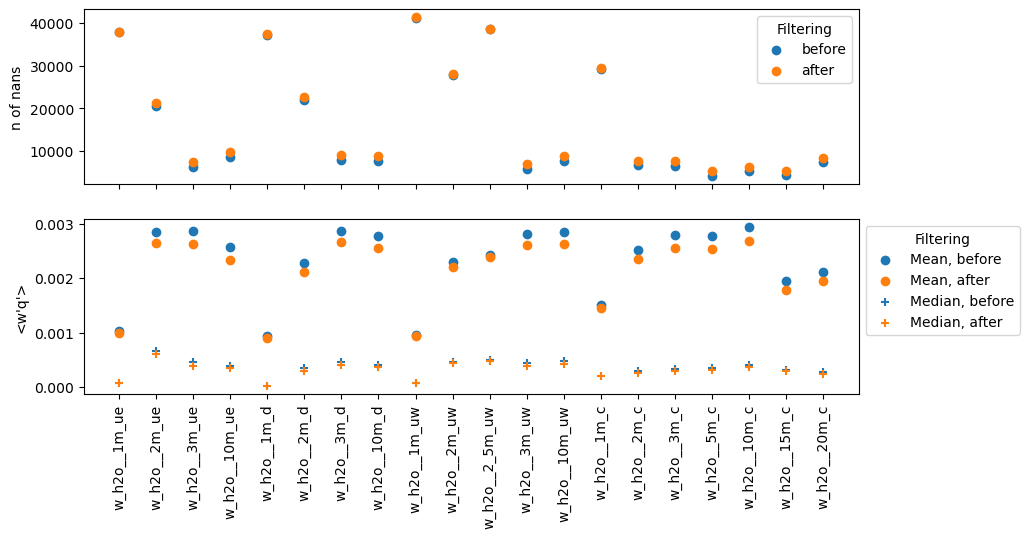

In [11]:
fig, axes = plt.subplots(2,1, sharex=True, figsize=(10,5))
axes[0].scatter(var_ls, old_nan_count_ls, label = 'before', color='tab:blue')
axes[0].set_ylabel("n of nans")
axes[0].scatter(var_ls, new_nan_count_ls, label = 'after', color='tab:orange')

axes[1].scatter(var_ls, old_mean_ls, label = 'Mean, before', color='tab:blue')
axes[1].set_ylabel("<w'q'>")
axes[1].scatter(var_ls, new_mean_ls, label = 'Mean, after', color='tab:orange')

axes[1].scatter(var_ls, old_median_ls, label = 'Median, before', marker='+', color='tab:blue')
axes[1].set_ylabel("<w'q'>")
axes[1].scatter(var_ls, new_median_ls, label = 'Median, after', marker='+', color='tab:orange')

for ax in axes:
    ax.tick_params(rotation=90, axis='x')
    ax.legend(title='Filtering', bbox_to_anchor=(1,1))

# Resample dataset

### Define dictionary defining the resampling function to use for each variable

Covariances are resampled according to the rules of **Reynold averaging** (https://www.eol.ucar.edu/content/combining-short-term-moments-longer-time-periods).

Meteorological and turbulence measurements (other than covariances) are resampled using the **mean**.

EC count variables are **summed**.

In [12]:
data_vars_processing_dict = {
    'reynolds_average': [
        'u_u__1m_uw',    'v_v__1m_uw',    'w_w__1m_uw',    'u_w__1m_uw',    'v_w__1m_uw',  'u_tc__1m_uw',  'v_tc__1m_uw',   'u_h2o__1m_uw',  'v_h2o__1m_uw',   'w_tc__1m_uw',   'w_h2o__1m_uw',
        'u_u__3m_uw',    'v_v__3m_uw',    'w_w__3m_uw',    'u_w__3m_uw',    'v_w__3m_uw',  'u_tc__3m_uw',  'v_tc__3m_uw',   'u_h2o__3m_uw',  'v_h2o__3m_uw',   'w_tc__3m_uw',   'w_h2o__3m_uw',
        'u_u__10m_uw',   'v_v__10m_uw',   'w_w__10m_uw',   'u_w__10m_uw',   'v_w__10m_uw', 'u_tc__10m_uw', 'v_tc__10m_uw',  'u_h2o__10m_uw', 'v_h2o__10m_uw',  'w_tc__10m_uw',  'w_h2o__10m_uw',
        'u_u__1m_ue',    'v_v__1m_ue',    'w_w__1m_ue',    'u_w__1m_ue',    'v_w__1m_ue',  'u_tc__1m_ue',  'v_tc__1m_ue',   'u_h2o__1m_ue',  'v_h2o__1m_ue',   'w_tc__1m_ue',   'w_h2o__1m_ue',
        'u_u__3m_ue',    'v_v__3m_ue',    'w_w__3m_ue',    'u_w__3m_ue',    'v_w__3m_ue',  'u_tc__3m_ue',  'v_tc__3m_ue',   'u_h2o__3m_ue',  'v_h2o__3m_ue',   'w_tc__3m_ue',   'w_h2o__3m_ue',
        'u_u__10m_ue',   'v_v__10m_ue',   'w_w__10m_ue',   'u_w__10m_ue',   'v_w__10m_ue', 'u_tc__10m_ue', 'v_tc__10m_ue',  'u_h2o__10m_ue', 'v_h2o__10m_ue',  'w_tc__10m_ue',  'w_h2o__10m_ue',
        'u_u__1m_d',     'v_v__1m_d',     'w_w__1m_d',     'u_w__1m_d',     'v_w__1m_d',   'u_tc__1m_d',   'v_tc__1m_d',    'u_h2o__1m_d',   'v_h2o__1m_d',    'w_tc__1m_d',    'w_h2o__1m_d',
        'u_u__3m_d',     'v_v__3m_d',     'w_w__3m_d',     'u_w__3m_d',     'v_w__3m_d',   'u_tc__3m_d',   'v_tc__3m_d',    'u_h2o__3m_d',   'v_h2o__3m_d',    'w_tc__3m_d',    'w_h2o__3m_d',
        'u_u__10m_d',    'v_v__10m_d',    'w_w__10m_d',    'u_w__10m_d',    'v_w__10m_d',  'u_tc__10m_d',  'v_tc__10m_d',   'u_h2o__10m_d',  'v_h2o__10m_d',   'w_tc__10m_d',   'w_h2o__10m_d',
        'u_u__2m_c',     'v_v__2m_c',     'w_w__2m_c',     'u_w__2m_c',     'v_w__2m_c',   'u_tc__2m_c',   'v_tc__2m_c',    'u_h2o__2m_c',   'v_h2o__2m_c',    'w_tc__2m_c',    'w_h2o__2m_c',
        'u_u__3m_c',     'v_v__3m_c',     'w_w__3m_c',     'u_w__3m_c',     'v_w__3m_c',   'u_tc__3m_c',   'v_tc__3m_c',    'u_h2o__3m_c',   'v_h2o__3m_c',    'w_tc__3m_c',    'w_h2o__3m_c',
        'u_u__5m_c',     'v_v__5m_c',     'w_w__5m_c',     'u_w__5m_c',     'v_w__5m_c',   'u_tc__5m_c',   'v_tc__5m_c',    'u_h2o__5m_c',   'v_h2o__5m_c',    'w_tc__5m_c',    'w_h2o__5m_c',
        'u_u__10m_c',    'v_v__10m_c',    'w_w__10m_c',    'u_w__10m_c',    'v_w__10m_c',  'u_tc__10m_c',  'v_tc__10m_c',   'u_h2o__10m_c',  'v_h2o__10m_c',   'w_tc__10m_c',   'w_h2o__10m_c',
        'u_u__15m_c',    'v_v__15m_c',    'w_w__15m_c',    'u_w__15m_c',    'v_w__15m_c',  'u_tc__15m_c',  'v_tc__15m_c',   'u_h2o__15m_c',  'v_h2o__15m_c',   'w_tc__15m_c',   'w_h2o__15m_c',
        'u_u__20m_c',    'v_v__20m_c',    'w_w__20m_c',    'u_w__20m_c',    'v_w__20m_c',  'u_tc__20m_c',  'v_tc__20m_c',   'u_h2o__20m_c',  'v_h2o__20m_c',   'w_tc__20m_c',   'w_h2o__20m_c',
    ],
    'average': [
        # Sonic anemometer data
        'h2o_1m_uw' ,       'tc_1m_uw',     'spd_1m_uw',    'dir_1m_uw',    'u_1m_uw',  'v_1m_uw',   'w_1m_uw',  
        'h2o_3m_uw' ,       'tc_3m_uw',     'spd_3m_uw',    'dir_3m_uw',    'u_3m_uw',  'v_3m_uw',   'w_3m_uw',  
        'h2o_10m_uw' ,      'tc_10m_uw',    'spd_10m_uw',   'dir_10m_uw',   'u_10m_uw', 'v_10m_uw',  'w_10m_uw',  
        'h2o_1m_ue' ,       'tc_1m_ue',     'spd_1m_ue',    'dir_1m_ue',    'u_1m_ue',  'v_1m_ue',   'w_1m_ue',  
        'h2o_3m_ue' ,       'tc_3m_ue',     'spd_3m_ue',    'dir_3m_ue',    'u_3m_ue',  'v_3m_ue',   'w_3m_ue',  
        'h2o_10m_ue' ,      'tc_10m_ue',    'spd_10m_ue',   'dir_10m_ue',   'u_10m_ue', 'v_10m_ue',  'w_10m_ue',  
        'h2o_1m_d' ,        'tc_1m_d',      'spd_1m_d',     'dir_1m_d',     'u_1m_d',   'v_1m_d',    'w_1m_d',  
        'h2o_3m_d' ,        'tc_3m_d',      'spd_3m_d',     'dir_3m_d',     'u_3m_d',   'v_3m_d',    'w_3m_d',  
        'h2o_10m_d' ,       'tc_10m_d',     'spd_10m_d',    'dir_10m_d',    'u_10m_d',  'v_10m_d',   'w_10m_d',  
        'h2o_2m_c' ,        'tc_2m_c',      'spd_2m_c',     'dir_2m_c',     'u_2m_c',   'v_2m_c',    'w_2m_c',  
        'h2o_3m_c' ,        'tc_3m_c',      'spd_3m_c',     'dir_3m_c',     'u_3m_c',   'v_3m_c',    'w_3m_c',  
        'h2o_5m_c' ,        'tc_5m_c',      'spd_5m_c',     'dir_5m_c',     'u_5m_c',   'v_5m_c',    'w_5m_c',  
        'h2o_10m_c' ,       'tc_10m_c',     'spd_10m_c',    'dir_10m_c',    'u_10m_c',  'v_10m_c',   'w_10m_c',  
        'h2o_15m_c' ,       'tc_15m_c',     'spd_15m_c',    'dir_15m_c',    'u_15m_c',  'v_15m_c',   'w_15m_c',  
        'h2o_20m_c' ,       'tc_20m_c',     'spd_20m_c',    'dir_20m_c',    'u_20m_c',  'v_20m_c',   'w_20m_c',  

        # Temperature & Relative Humidity Array 
        'T_1m_c', 'T_2m_c', 'T_3m_c', 'T_4m_c', 'T_5m_c', 'T_6m_c', 'T_7m_c', 'T_8m_c', 'T_9m_c', 'T_10m_c',
        'T_11m_c', 'T_12m_c', 'T_13m_c', 'T_14m_c', 'T_15m_c', 'T_16m_c', 'T_17m_c', 'T_18m_c', 'T_19m_c', 'T_20m_c',

        'RH_1m_c', 'RH_2m_c', 'RH_3m_c', 'RH_4m_c', 'RH_5m_c', 'RH_6m_c', 'RH_7m_c', 'RH_8m_c', 'RH_9m_c', 'RH_10m_c',
        'RH_11m_c','RH_12m_c','RH_13m_c','RH_14m_c','RH_15m_c','RH_16m_c','RH_17m_c','RH_18m_c','RH_19m_c','RH_20m_c',

        # Pressure Sensors
        'P_20m_c',
        'P_10m_c', 'P_10m_d', 'P_10m_uw', 'P_10m_ue',

        # Blowing snow/FlowCapt Sensors
        'SF_avg_1m_ue', 'SF_avg_2m_ue',

        # Apogee sensors
        "Vtherm_c", "Vtherm_d", "Vtherm_ue", "Vtherm_uw", 
        "Vpile_c", "Vpile_d", "Vpile_ue", "Vpile_uw",
        "IDir_c", "IDir_d", "IDir_ue", "IDir_uw",

        # Snow-level temperature arrays (towers D and UW)
        'Tsnow_0_4m_d', 'Tsnow_0_5m_d', 'Tsnow_0_6m_d', 'Tsnow_0_7m_d', 'Tsnow_0_8m_d', 'Tsnow_0_9m_d', 'Tsnow_1_0m_d', 'Tsnow_1_1m_d', 'Tsnow_1_2m_d', 'Tsnow_1_3m_d', 'Tsnow_1_4m_d', 'Tsnow_1_5m_d',
        'Tsnow_0_4m_uw', 'Tsnow_0_5m_uw', 'Tsnow_0_6m_uw', 'Tsnow_0_7m_uw', 'Tsnow_0_8m_uw', 'Tsnow_0_9m_uw', 'Tsnow_1_0m_uw', 'Tsnow_1_1m_uw', 'Tsnow_1_2m_uw', 'Tsnow_1_3m_uw', 'Tsnow_1_4m_uw', 'Tsnow_1_5m_uw',
        
        # Downward Facing Longwave Radiometer (tower D) - for measuring snow surface temperature
        'Rpile_out_9m_d',
        'Tcase_out_9m_d',    
        # Upward Facing Longwave Radiometer (tower D)
        'Rpile_in_9m_d',
        'Tcase_in_9m_d',
        # Downward Facing Longwave Radiometer (tower UW) - for measuring snow surface temperature
        'Tcase_uw', 'Rpile_in_uw', 'Rpile_out_uw',
        
        # Upward facing shortwave radiometer (tower D) - for measuring incoming solar radiation!
        'Rsw_in_9m_d',
        'Rsw_out_9m_d',

        # Snow Pillow SWE
        'SWE_p1_c', 'SWE_p2_c', 'SWE_p3_c', 'SWE_p4_c',

        # Soil Moisture
        'Qsoil_d',
        
        # Diagnostic variables for irga and sonic
        'irgadiag_1m_c',    'ldiag_1m_c',
        'irgadiag_2m_c',    'ldiag_2m_c',
        'irgadiag_3m_c',    'ldiag_3m_c',
        'irgadiag_5m_c',    'ldiag_5m_c',
        'irgadiag_10m_c',   'ldiag_10m_c',
        'irgadiag_15m_c',   'ldiag_15m_c',
        'irgadiag_20m_c',   'ldiag_20m_c',
        'irgadiag_1m_uw',   'ldiag_1m_uw',
        'irgadiag_3m_uw',   'ldiag_3m_uw',
        'irgadiag_10m_uw',  'ldiag_10m_uw',
        'irgadiag_1m_ue',   'ldiag_1m_ue',
        'irgadiag_3m_ue',   'ldiag_3m_ue',
        'irgadiag_10m_ue',  'ldiag_10m_ue',
        'irgadiag_1m_d',    'ldiag_1m_d',
        'irgadiag_3m_d',    'ldiag_3m_d',
        'irgadiag_10m_d',   'ldiag_10m_d',
    ],
    'sum' : [
        # Counts of unflagged instantaneous (20hz) eddy covariance measurements
        # momentum flux flags   LHFlux flags   SH flux flags       
        'counts_1m_c',    'counts_1m_c_1',    'counts_1m_c_2',    
        'counts_2m_c',    'counts_2m_c_1',    'counts_2m_c_2',    
        'counts_3m_c',    'counts_3m_c_1',    'counts_3m_c_2',    
        'counts_5m_c',    'counts_5m_c_1',    'counts_5m_c_2',    
        'counts_10m_c',   'counts_10m_c_1',   'counts_10m_c_2',   
        'counts_15m_c',   'counts_15m_c_1',   'counts_15m_c_2',   
        'counts_20m_c',   'counts_20m_c_1',   'counts_20m_c_2',   
        'counts_1m_uw',   'counts_1m_uw_1',   'counts_1m_uw_2',   
        'counts_3m_uw',   'counts_3m_uw_1',   'counts_3m_uw_2',   
        'counts_10m_uw',  'counts_10m_uw_1',  'counts_10m_uw_2',  
        'counts_1m_ue',   'counts_1m_ue_1',   'counts_1m_ue_2',   
        'counts_3m_ue',   'counts_3m_ue_1',   'counts_3m_ue_2',   
        'counts_10m_ue',  'counts_10m_ue_1',  'counts_10m_ue_2',  
        'counts_1m_d',    'counts_1m_d_1',    'counts_1m_d_2',    
        'counts_3m_d',    'counts_3m_d_1',    'counts_3m_d_2',    
        'counts_10m_d',   'counts_10m_d_1',   'counts_10m_d_2',   
    ]
}

### Resample each variable separately

In [16]:

def get_resampled_data_vars(resample_period_minutes = 30):
    """Resample period should be a multiple of 5""" 
    resample_string = f'{resample_period_minutes}Min'
    resample_n = resample_period_minutes/5
    new_data_vars = {}
    for key in data_vars_processing_dict.keys():
        for var in data_vars_processing_dict[key]:
            if var in sos_ds:
                if key == 'reynolds_average':
                    comp1, comp2 = var.split('__')[0].split('_')
                    ending = var.split('__')[1]
                    comp1_var_name = comp1+'_'+ending
                    comp2_var_name = comp2+'_'+ending
                    new_cov_part1 = (1/resample_n)*(sos_ds[var] + sos_ds[comp1_var_name]*sos_ds[comp2_var_name])
                    new_cov_part2 = (1/resample_n)*sos_ds[comp1_var_name]
                    new_cov_part3 = (1/resample_n)*sos_ds[comp2_var_name]
                    new_cov = new_cov_part1.resample(time=resample_string).sum() - ( 
                        new_cov_part2.resample(time=resample_string).sum()* new_cov_part3.resample(time=resample_string).sum() 
                    )
                    new_data_vars[var] = new_cov
                elif key == 'average':
                    new_data_vars[var] = sos_ds[var].resample(time=resample_string).mean()
                elif key == 'sum':
                    new_data_vars[var] = sos_ds[var].resample(time=resample_string).sum()
    return xr.Dataset(new_data_vars)

In [22]:

def get_resampled_data_vars_parallel(resample_period_minutes = 30, parallelism=8):
    """Resample period should be a multiple of 5""" 
    resample_string = f'{resample_period_minutes}Min'
    resample_n = resample_period_minutes/5

    # create list of keys and vars so we don't need a double nested for loop
    key_var_ls = []
    for key in data_vars_processing_dict.keys():
        for var in data_vars_processing_dict[key]:
            key_var_ls.append((key,var))
    
    def resample_var(key_var_pair):
        key,var = key_var_pair
        if var in sos_ds:
            if key == 'reynolds_average':
                comp1, comp2 = var.split('__')[0].split('_')
                ending = var.split('__')[1]
                comp1_var_name = comp1+'_'+ending
                comp2_var_name = comp2+'_'+ending
                new_cov_part1 = (1/resample_n)*(sos_ds[var] + sos_ds[comp1_var_name]*sos_ds[comp2_var_name])
                new_cov_part2 = (1/resample_n)*sos_ds[comp1_var_name]
                new_cov_part3 = (1/resample_n)*sos_ds[comp2_var_name]
                new_cov = new_cov_part1.resample(time=resample_string).sum() - ( 
                    new_cov_part2.resample(time=resample_string).sum()* new_cov_part3.resample(time=resample_string).sum() 
                )
                return var, new_cov
            elif key == 'average':
                return var, sos_ds[var].resample(time=resample_string).mean()
            elif key == 'sum':
                return var, sos_ds[var].resample(time=resample_string).sum()
        else:
            return None
    
    from tqdm import tqdm
    from multiprocess import Pool
    max_pool = parallelism
    with Pool(max_pool) as p:
        resample_data_outputs = list(tqdm(
                p.imap(resample_var,key_var_ls),
                total=len(key_var_ls)
        ))    
    return xr.Dataset(resample_data_outputs)

### Create new dataset from resampled variables

In [23]:
sos_ds_30min = get_resampled_data_vars_parallel(resample_period_minutes = 30, parallelism=8)

 61%|██████    | 271/447 [02:22<02:55,  1.00it/s]

In [17]:
old_ds = sos_ds

# sos_ds_10min = get_resampled_data_vars(10)
sos_ds_30min = get_resampled_data_vars(30)
# sos_ds_60min = get_resampled_data_vars(60)
# sos_ds_120min = get_resampled_data_vars(120)

sos_ds = sos_ds_30min

reynolds_average u_u__1m_uw
reynolds_average v_v__1m_uw
reynolds_average w_w__1m_uw
reynolds_average u_w__1m_uw
reynolds_average v_w__1m_uw
reynolds_average u_tc__1m_uw
reynolds_average v_tc__1m_uw
reynolds_average u_h2o__1m_uw
reynolds_average v_h2o__1m_uw
reynolds_average w_tc__1m_uw
reynolds_average w_h2o__1m_uw
reynolds_average u_u__3m_uw
reynolds_average v_v__3m_uw
reynolds_average w_w__3m_uw
reynolds_average u_w__3m_uw
reynolds_average v_w__3m_uw


KeyboardInterrupt: 

In [ ]:
sos_ds

### Compare total sublimation across averaging periods

In [ ]:
from metpy.constants import density_water

In [ ]:
lhflux_vars =[
    # 'w_h2o__1m_uw',
    'w_h2o__3m_uw',
    'w_h2o__10m_uw',
    # 'w_h2o__1m_ue',
    'w_h2o__3m_ue',
    'w_h2o__10m_ue',
    # 'w_h2o__1m_d',
    'w_h2o__3m_d',
    'w_h2o__10m_d',
    # 'w_h2o__2m_c',
    'w_h2o__3m_c',
    'w_h2o__5m_c',
    'w_h2o__10m_c',
    'w_h2o__15m_c',
    'w_h2o__20m_c',
]
old_ds_mean_lhflux = old_ds[lhflux_vars].to_dataframe().mean()
sos_ds_10min_mean_lhflux = sos_ds_10min[lhflux_vars].to_dataframe().mean()
sos_ds_30min_mean_lhflux = sos_ds_30min[lhflux_vars].to_dataframe().mean()
sos_ds_60min_mean_lhflux = sos_ds_60min[lhflux_vars].to_dataframe().mean()
sos_ds_120min_mean_lhflux = sos_ds_120min[lhflux_vars].to_dataframe().mean()

mean_lhflux_estimates = pd.concat([
    pd.DataFrame(old_ds_mean_lhflux).rename(columns={0:'5min'}),
    pd.DataFrame(sos_ds_10min_mean_lhflux).rename(columns={0:'10min'}),
    pd.DataFrame(sos_ds_30min_mean_lhflux).rename(columns={0:'30min'}),
    pd.DataFrame(sos_ds_60min_mean_lhflux).rename(columns={0:'60min'}),
    pd.DataFrame(sos_ds_120min_mean_lhflux).rename(columns={0:'120min'}),
], axis=1)
mean_lhflux_estimates.index.name = 'location'
mean_lhflux_estimates = mean_lhflux_estimates.reset_index()
mean_lhflux_estimates
mean_lhflux_estimates['height'] = mean_lhflux_estimates['location'].apply(lambda s: int(s.split('__')[1].split('m_')[0]))
mean_lhflux_estimates['tower'] = mean_lhflux_estimates['location'].apply(lambda s: s.split('_')[-1])
mean_lhflux_estimates
lhflux_estimates_chart = alt.Chart(mean_lhflux_estimates).transform_fold(
    ['5min', '10min', '30min', '60min', '120min']
).mark_point().encode(
    alt.X("key:O").sort(['5min', '10min', '30min', '60min', '120min']).title("Reynolds Avg Length").axis(None).title(None),
    alt.Y("value:Q").scale(zero=False).title("Mean w'q' (g/m^2/s)"),
    alt.Color("tower:N"),
    alt.Facet("height:O").title("Instrument height (m)")
).properties(height = 100)

In [ ]:
old_ds_sum_lhflux = old_ds[lhflux_vars].to_dataframe().sum()*60*5/density_water.magnitude
sos_ds_10min_sum_lhflux = sos_ds_10min[lhflux_vars].to_dataframe().sum()*60*10/density_water.magnitude
sos_ds_30min_sum_lhflux = sos_ds_30min[lhflux_vars].to_dataframe().sum()*60*30/density_water.magnitude
sos_ds_60min_sum_lhflux = sos_ds_60min[lhflux_vars].to_dataframe().sum()*60*60/density_water.magnitude
sos_ds_120min_sum_lhflux = sos_ds_120min[lhflux_vars].to_dataframe().sum()*60*120/density_water.magnitude

sum_lhflux_estimates = pd.concat([
    pd.DataFrame(old_ds_sum_lhflux).rename(columns={0:'5min'}),
    pd.DataFrame(sos_ds_10min_sum_lhflux).rename(columns={0:'10min'}),
    pd.DataFrame(sos_ds_30min_sum_lhflux).rename(columns={0:'30min'}),
    pd.DataFrame(sos_ds_60min_sum_lhflux).rename(columns={0:'60min'}),
    pd.DataFrame(sos_ds_120min_sum_lhflux).rename(columns={0:'120min'}),
], axis=1)
sum_lhflux_estimates.index.name = 'location'
sum_lhflux_estimates = sum_lhflux_estimates.reset_index()
sum_lhflux_estimates
sum_lhflux_estimates['height'] = sum_lhflux_estimates['location'].apply(lambda s: int(s.split('__')[1].split('m_')[0]))
sum_lhflux_estimates['tower'] = sum_lhflux_estimates['location'].apply(lambda s: s.split('_')[-1])
sum_lhflux_estimates
cumsub_estimates_chart = alt.Chart(sum_lhflux_estimates).transform_fold(
    ['5min', '10min', '30min', '60min', '120min']
).mark_point().encode(
    alt.X("key:O").sort(['5min', '10min', '30min', '60min', '120min']).title("Reynolds Avg Length").axis(None).title(None),
    alt.Y("value:Q").scale(zero=False).title("Sublimation (mm)"),
    alt.Color("tower:N"),
    alt.Facet("height:O").title("Instrument height (m)")
).properties(height = 100)

In [ ]:
shflux_vars =[
    # 'w_tc__1m_uw',
    'w_tc__3m_uw',
    'w_tc__10m_uw',
    # 'w_tc__1m_ue',
    'w_tc__3m_ue',
    'w_tc__10m_ue',
    # 'w_tc__1m_d',
    'w_tc__3m_d',
    'w_tc__10m_d',
    # 'w_tc__2m_c',
    'w_tc__3m_c',
    'w_tc__5m_c',
    'w_tc__10m_c',
    'w_tc__15m_c',
    'w_tc__20m_c',
]
old_ds_mean_shflux = old_ds[shflux_vars].to_dataframe().mean()
sos_ds_10min_mean_shflux = sos_ds_10min[shflux_vars].to_dataframe().mean()
sos_ds_30min_mean_shflux = sos_ds_30min[shflux_vars].to_dataframe().mean()
sos_ds_60min_mean_shflux = sos_ds_60min[shflux_vars].to_dataframe().mean()
sos_ds_120min_mean_shflux = sos_ds_120min[shflux_vars].to_dataframe().mean()

mean_shflux_estimates = pd.concat([
    pd.DataFrame(old_ds_mean_shflux).rename(columns={0:'5min'}),
    pd.DataFrame(sos_ds_10min_mean_shflux).rename(columns={0:'10min'}),
    pd.DataFrame(sos_ds_30min_mean_shflux).rename(columns={0:'30min'}),
    pd.DataFrame(sos_ds_60min_mean_shflux).rename(columns={0:'60min'}),
    pd.DataFrame(sos_ds_120min_mean_shflux).rename(columns={0:'120min'}),
], axis=1)
mean_shflux_estimates.index.name = 'location'
mean_shflux_estimates = mean_shflux_estimates.reset_index()
mean_shflux_estimates
mean_shflux_estimates['height'] = mean_shflux_estimates['location'].apply(lambda s: int(s.split('__')[1].split('m_')[0]))
mean_shflux_estimates['tower'] = mean_shflux_estimates['location'].apply(lambda s: s.split('_')[-1])
mean_shflux_estimates
shflux_estimates_chart = alt.Chart(mean_shflux_estimates).transform_fold(
    ['5min', '10min', '30min', '60min', '120min']
).mark_point().encode(
    alt.X("key:O").sort(['5min', '10min', '30min', '60min', '120min']).title("Reynolds Avg Length"),
    alt.Y("value:Q").scale(zero=False).title("Mean w'T' (˚C*m/s)"),
    alt.Color("tower:N"),
    alt.Facet("height:O").title(None).header(labelFontSize=0)
).properties(height = 100)

In [ ]:
cumsub_estimates_chart & lhflux_estimates_chart & shflux_estimates_chart

### Copy attributes for dataset and individual variables.

In [ ]:

sos_ds.attrs = old_ds.attrs
for data_var in sos_ds:
    sos_ds[data_var].attrs = old_ds[data_var].attrs

# Add additional variables

## Add snow depth

Open snow depth data

In [ ]:
snowc_dataset = xr.open_dataset("~/Development/data/sublimationofsnow/lidar_snow_depth/C_l2.nc")
lidar_snowdepth_da = snowc_dataset.resample(time='1440Min').median()['surface']
lidar_snowdepth_da = lidar_snowdepth_da.interpolate_na(dim = 'time', method='linear')
lidar_snowdepth_da = lidar_snowdepth_da.where(lidar_snowdepth_da > 0, 0)
lidar_snowdepth_upsample_da = lidar_snowdepth_da.resample(time = '30min').pad()
lidar_snowdepth_da.plot()
lidar_snowdepth_upsample_da.plot()
plt.show()

In [ ]:
snowdepth_df = lidar_snowdepth_upsample_da.loc[
    sos_ds.time.min():sos_ds.time.max()
].to_dataframe()


# Option 2: Add as a variable
snowdepth_df = snowdepth_df.reset_index()
snowdepth_df = snowdepth_df[snowdepth_df.time.isin(sos_ds.time.values)]
snowdepth_df

In [ ]:
sos_ds['SnowDepth_c'] = (['time'],  snowdepth_df.surface.values)

## Add/calculate longwave radiation and surface temperatures

In [ ]:
sos_ds = variables.add_longwave_radiation(sos_ds)
sos_ds = variables.add_surface_temps(sos_ds)

### Clean $T_s$ variables before proceeding with other calculations

(as of Feb 20, 2023, using NCAR's QC data release, we found a single $T_s$ outlier.)

In [ ]:
Tsurf_vars = [v for v in sos_ds.data_vars if v.startswith('Tsurf')]
Tsurf_vars

In [ ]:
for var in Tsurf_vars:
    print(sos_ds[var].max())
    print(sos_ds[var].min())

In [ ]:
for var in Tsurf_vars:
    sos_ds[var] = sos_ds[var].where(
        sos_ds[var].values < 40
    ).interpolate_na(
        dim='time', 
        method='linear'
    ).where(
        ~ sos_ds[var].isnull()
    )

In [ ]:
for var in Tsurf_vars:
    print(sos_ds[var].max())
    print(sos_ds[var].min())

## Add $T_v, \theta, \theta_v, \textbf{tke}, R_i, L$

In [ ]:
sos_ds = variables.add_potential_virtual_temperatures(sos_ds)
sos_ds = variables.add_surface_potential_virtual_temperatures(sos_ds)
sos_ds = variables.add_tke(sos_ds)
sos_ds = variables.add_gradients_and_ri(sos_ds)
sos_ds = variables.add_shear_velocity_and_obukhov_length(sos_ds)

In [ ]:
tidy_old = pd.read_parquet(f'tidy_df_{start_date}_{end_date}_noplanar_fit.parquet')

## Add decoupling metric, from Peltola et al. (2021).

We adjust the height value for snow depth.

In [ ]:
def decoupling_metric(z, sigma_w, N):
    """Calculate the decoupling metric as described in Peltola et al (2021).

    Peltola, O., Lapo, K., & Thomas, C. K. (2021). A Physics‐Based Universal Indicator for Vertical Decoupling and Mixing Across Canopies Architectures and Dynamic Stabilities. Geophysical Research Letters, 48(5), e2020GL091615. https://doi.org/10.1029/2020GL091615
    
    Args:
        z (float): height of measurements 
        sigma_w (float): standarad deviation of w, vertical velocity
        N (float): Brunt-Vaisala frequency
    """
    # Brunt Vaisala frequency estimated using the bulk theta gradient
    # N = np.sqrt(
    #     g * (theta_e - theta_mean) / theta_mean
    # )

    Lb = sigma_w / N
    omega = Lb / ( np.sqrt(2)*z )
    return omega


In [ ]:
#######################################################################
### OLD METHOD USING GRADIENT-BASED N
#######################################################################
from metpy.calc import brunt_vaisala_frequency

sigma_w = np.sqrt(sos_ds['w_w__3m_c']).values
pot_temps = sos_ds[[
    'Tpot_2m_c', 
    'Tpot_3m_c', 
    'Tpot_4m_c', 
    'Tpot_5m_c', 
    'Tpot_6m_c'
]].to_stacked_array(
    'z', ['time']
).values

snow_depth_values = sos_ds['SnowDepth_c']
snow_depth_values_reshaped = np.repeat(sos_ds['SnowDepth_c'].values, 5).reshape(-1, 5)

heights = np.full(pot_temps.shape,  [ 2,    3,    4,    5,    6])
heights_adjusted = heights - snow_depth_values_reshaped
brunt_vaisala_values = [ Ns[1] for Ns in 
    brunt_vaisala_frequency( 
        heights_adjusted * units("meters"),
        pot_temps * units("celsius"), 
        vertical_dim=1
    ).magnitude   
]
z = np.full(sigma_w.shape, 3) - snow_depth_values.values

# decoupling_metric(z, sigma_w, N)
print(len(z))
print(len(sigma_w))
print(len(brunt_vaisala_values))

omegas = decoupling_metric(z, sigma_w, brunt_vaisala_values)
sos_ds['omega_3m_c'] = (['time'],  omegas)
print(len(omegas))



#######################################################################
### NEW METHOD USING BULK N
#######################################################################
# sigma_w = np.sqrt(sos_ds['w_w__3m_c']).values

# snow_depth_values = sos_ds['SnowDepth_c'].values

# air_temp_height = 3
# heights_adjusted = air_temp_height - snow_depth_values
# surf_pottemp = sos_ds['Tsurfpot_c'].values
# air_pottemp = sos_ds['Tpot_3m_c'].values
# surfacealyer_avg_pottemp = 0.5*(air_pottemp + surf_pottemp)
# bulk_brunt_vaisala_value = np.sqrt(
#     metpy.constants.earth_gravity.magnitude.item()*(air_pottemp - surfacealyer_avg_pottemp) 
#     /
#     (surfacealyer_avg_pottemp * heights_adjusted)
# )
# z = np.full(sigma_w.shape, 3) - snow_depth_values

# # decoupling_metric(z, sigma_w, N)
# print(len(z))
# print(len(sigma_w))
# print(len(bulk_brunt_vaisala_value))

# omegas = decoupling_metric(z, sigma_w, bulk_brunt_vaisala_value)
# sos_ds['omega_3m_c'] = (['time'],  omegas)

In [ ]:
import seaborn as sns
sns.histplot(sos_ds['omega_3m_c'])
plt.xlim(0,1)

## Net LW and Net SW

In [ ]:
sos_ds['Rlw_net_9m_d'] = sos_ds['Rlw_in_9m_d'] - sos_ds['Rlw_out_9m_d']
sos_ds['Rsw_net_9m_d'] = sos_ds['Rsw_in_9m_d'] - sos_ds['Rsw_out_9m_d']

## Net Radiation

In [ ]:
sos_ds['Rnet_9m_d'] = (
    (sos_ds['Rsw_in_9m_d'] + sos_ds['Rlw_in_9m_d'])
    -
    (sos_ds['Rsw_out_9m_d'] + sos_ds['Rlw_out_9m_d'])
)

## Specific humidity

In [ ]:
for var in [
    'Tsurfmixingratio_c',
    'mixingratio_2m_c',
    'mixingratio_3m_c',
    'mixingratio_4m_c',
    'mixingratio_5m_c',
    'mixingratio_6m_c',
    'mixingratio_7m_c',
    'mixingratio_8m_c',
    'mixingratio_9m_c',
    'mixingratio_10m_c',
    'mixingratio_11m_c',
    'mixingratio_12m_c',
    'mixingratio_13m_c',
    'mixingratio_14m_c',
    'mixingratio_15m_c',
    'mixingratio_16m_c',
    'mixingratio_17m_c',
    'mixingratio_18m_c',
    'mixingratio_19m_c',
    'mixingratio_20m_c',
]:
    new_var_name = var.replace('mixingratio', 'specifichumidity')
    sos_ds[new_var_name] = (['time'], specific_humidity_from_mixing_ratio(
        sos_ds[var]*units('g/g')
    ).values)

# Apply sensible and latent heat flux corrections (lots of citations, see here: https://www.eol.ucar.edu/content/corrections-sensible-and-latent-heat-flux-measurements)

In [ ]:
rho_d = 1293 #g/m^3, density of dry air
rho_a = 1287 #g/m^3, density of moist air
mu = 1/0.622

def corrected_sensible_heat_flux(
    w_tc_, #sonic_temperature_flux
    w_h2o_, #h2o_flux
    Q, #specific_humidity
    T, #absolute_temperature
    A, #A
    Mr, #mean_mixing_ratio
):
    Ctc = 0.51*(1 + Q*(mu-1))
    return (
        w_tc_ - Ctc*(T/rho_a)*A*w_h2o_
    ) / (
        1 + Ctc*Q
    )

def corrected_latent_heat_flux(
    w_tc_, #sonic_temperature_flux
    w_h2o_, #h2o_flux
    Q, #specific_humidity
    T, #absolute_temperature
    A, #A
    Mr, #mean_mixing_ratio
):
    Ctc = 0.51*(1 + Q*(mu-1))
    return (1 + mu*Mr)* (
        (A/rho_d)*w_h2o_ + (Mr/T)*(w_tc_)
    ) / (
        1 + Ctc*Q
    )

# Get Tidy Dataset

In [ ]:
tidy_df = tidy.get_tidy_dataset(sos_ds, list(sos_ds.data_vars))

In [ ]:
tidy_df.query("variable == 'Tsurf_d'").set_index('time')['value'].plot()

In [ ]:
tidy_df.query("variable == 'u*_3m_c'").variable.unique()

In [ ]:
assert len(tidy_df.query("variable == 'omega_3m_c'")) > 0

Which variables did not get a "measurement" name assigned?

In [ ]:
variables_with_no_measurement = tidy_df[tidy_df.measurement.apply(lambda x: x is None)].variable.unique()
variables_with_no_measurement

In [ ]:
set(tidy_df.variable.unique()).difference(set(list(sos_ds.data_vars)))

# Model Estimates

## Penman-Monteith and Priestley-Taylor

### Gather the data we need

In [ ]:
pyet_src = tidy_df[tidy_df.variable.isin([
    'Rnet_9m_d',
    'airdensity_3m_c',
    'Tsurfvaporpressure_c',
    'vaporpressure_3m_c',
    'T_3m_c',
    'spd_3m_c',
    'P_10m_c'
])].pivot_table(
    index=['time'],
    values='value',
    columns='variable'
# Calculate means across 30min periods, mins and maxes for the required variables too
).reset_index()
pyet_src.head(2)

In [ ]:
# From PyET code
# Equation for calculating the latent heat of vaporization from:
# Richard G Allen, Luis S Pereira, Dirk Raes, Martin Smith, and others. Crop evapotranspiration-Guidelines for computing crop 
# water requirements-FAO Irrigation and drainage paper 56. Fao, Rome, 300(9):D05109, 1998.
pyet_src['L_v estimated'] = 2.501 - 0.002361 * pyet_src['T_3m_c']

### Define function

In [ ]:
import pyet

In [ ]:
def calc_delta_alduchov(t_in_c):
# Taking the derivative of the Alduchov curve
# returns in kPa
    numerator = 37836.5*np.exp((22.587*t_in_c)/(273.86+t_in_c))
    denominator = (t_in_c + 273.86)**2
    # 0.1 to convert from millibars to kPa
    return 0.1*numerator/denominator

def calc_psychrometric_constant(C_p, P, L_v):
    # C_p in MJ/kg/˚C
    # P in kPa
    # L_v in MJ/kg
    # From wikipedia
    # https://en.wikipedia.org/wiki/Psychrometric_constant#cite_note-1
    # which cites this:
    #  Allen, R.G.; Pereira, L.S.; Raes, D.; Smith, M. (1998). Crop Evapotranspiration—Guidelines for Computing Crop Water Requirements. 
    # FAO Irrigation and drainage paper 56. Rome, Italy: Food and Agriculture Organization of the United Nations. ISBN 92-5-104219-5. Retrieved 2007-10-08.
    return C_p*P/(0.622 * L_v)

In [ ]:
C_p = 1.013 * 10 ** -3  # MJ/kg/K

def penman_monteith(
    energy_available, # MJ/m^2/day
    density_air, # kg/m^3
    vapor_pressure_surface, # kPa
    vapor_pressure_air, # kPa
    temp_air, # ˚C
    pressure, # kPa
    wind_speed, # m/s
    L_v
):
    A = energy_available
    rho_a = density_air
    e_s = vapor_pressure_surface
    e_a = vapor_pressure_air
    
    # delta = pyet.calc_vpc(temp_air)
    delta = calc_delta_alduchov(temp_air)
    y = calc_psychrometric_constant(C_p, pressure, L_v)
    r_a = pyet.calc_res_aero(wind_speed) # I should replace this with some better method for estimating atmospheric resistance - i.e. see Mahrt and Vickers, 2005, i.e. r_a = 1/(wind_speed * C_q)
    r_s = 0

    numerator = delta*A + rho_a*86400*C_p*(e_s - e_a)/r_a
    denominator = delta + y*(1 + r_s / r_a)
    return (1/L_v)*(numerator/denominator)

### Do calculations

In [ ]:
pyet_src['pm results'] = penman_monteith(
    (pyet_src['Rnet_9m_d'].to_xarray() * units("W/m^2")).pint.to("MJ/m^2/day").values,
    pyet_src['airdensity_3m_c'].values,
    (pyet_src['Tsurfvaporpressure_c'].to_xarray() * units("Pa")).pint.to("kPa").values,
    (pyet_src['vaporpressure_3m_c'].to_xarray() * units("Pa")).pint.to("kPa").values,
    pyet_src['T_3m_c'].values,
    (pyet_src['P_10m_c'].to_xarray() * units("millibars")).pint.to("kPa").values,
    pyet_src['spd_3m_c'].values,
    pyet_src['L_v estimated'].values
)

### Convert from mm/day to g/m^2/s

In [ ]:
pyet_src['pm results'] = pyet_src['pm results']/(86.4)

In [ ]:
pyet_src.set_index('time')['pm results'].plot(alpha=0.5)

In [ ]:
pyet_src.set_index('time')['pm results'].cumsum().plot(alpha=0.5)

### Add to tidy df

Fill missing timestamps with NaNs

In [ ]:
pm_values = tidy_df.query("variable == 'spd_3m_c'").merge(
    pyet_src[['time', 'pm results']],
    on='time',
    how='left'
)['pm results'].values

In [ ]:
tidy_df = tidy.tidy_df_add_variable(
    tidy_df,
    pm_values,
    f'w_h2o__3m_c predicted (Penman Monteith)',
    'w_h2o_',
    3,
    'c'
)

## MOST (my iterative solution, in most.py)

Prepare the input data we need

In [ ]:
# EXTRACT VARIABLES
VARIABLES = [
    ## Input Variables
    'spd_3m_c',
    'Tpot_3m_c',
    'Tsurfpot_c',
    'airdensity_3m_c',
    'mixingratio_3m_c',
    'Tsurfmixingratio_c',
    'T_3m_c',
    ## Measurement Variables
    'w_h2o__3m_c',
    'w_tc__3m_c',
    'u*_3m_c',
    'Ri_3m_c',
]
print([ v for v in tidy_df.variable.unique() if v in VARIABLES ])

# CREATE WIDE DATAFRAME
variables_df = tidy_df[tidy_df.variable.isin(VARIABLES)].pivot_table(
    values = 'value',
    index = 'time',
    columns='variable'
).reset_index()

# MAKE CONVERSIONS
# convert from ˚C to K
variables_df['T_3m_c'] = variables_df['T_3m_c'] + 273.15
variables_df['Tpot_3m_c'] = variables_df['Tpot_3m_c'] + 273.15
variables_df['Tsurfpot_c'] = variables_df['Tsurfpot_c'] + 273.15
# comes in units of g/g
variables_df['specifichumidity_3m_c'] = specific_humidity_from_mixing_ratio(
    xr.DataArray(variables_df['mixingratio_3m_c'])*units('g/g')
).pint.to('g/kg').values
# comes in units of g/g,  solution requires it in units of g/kg
variables_df['specifichumidity_surface_c'] = specific_humidity_from_mixing_ratio(
    xr.DataArray(variables_df['Tsurfmixingratio_c'])*units('g/g')
).pint.to('g/kg').values



# CREATE MEASUREMENT HEIGHT VARIABLES
variables_df['measurement_height'] = 3

In [ ]:
import sys
sys.path.append('../paper1/')
from most import MOST, StabilityFunctionBrutsaert1982

most_config_dict = {
    0.00001: MOST(StabilityFunctionBrutsaert1982(), snow_surface_roughness = 0.00001),
    0.00005: MOST(StabilityFunctionBrutsaert1982(), snow_surface_roughness = 0.00005),
    0.0001: MOST(StabilityFunctionBrutsaert1982(), snow_surface_roughness = 0.0001),
    0.0005: MOST(StabilityFunctionBrutsaert1982(), snow_surface_roughness = 0.0005),
    0.001: MOST(StabilityFunctionBrutsaert1982(), snow_surface_roughness = 0.001),
    0.005: MOST(StabilityFunctionBrutsaert1982(), snow_surface_roughness = 0.005),
}

for z0, this_most in most_config_dict.items():
    L_solutions, u_friction_solutions, H_solutions, E_solutions = this_most.solve(
        variables_df['spd_3m_c'],
        variables_df['Tpot_3m_c'],
        variables_df['Tsurfpot_c'],
        variables_df['airdensity_3m_c'],
        variables_df['specifichumidity_3m_c'],
        variables_df['specifichumidity_surface_c'],
        variables_df['T_3m_c'],
        variables_df['measurement_height']
    )

    variables_df[f'L_solution_z0_{str(z0)}'] = L_solutions
    variables_df[f'u_friction_solution_z0_{str(z0)}'] = u_friction_solutions
    variables_df[f'H_solution_z0_{str(z0)}'] = H_solutions
    variables_df[f'E_solution_z0_{str(z0)}'] = E_solutions

    # convert from W/m^2 to ˚C*m/s
    variables_df[f'H_solution_z0_{str(z0)}'] = (variables_df[f'H_solution_z0_{str(z0)}']/(variables_df['airdensity_3m_c']*0.718*1000))

Add nans for the model results where there are missing timesteps (As compared to the tidy dataset of measurements)

In [ ]:
variables_df['time'] = pd.to_datetime(variables_df['time'])

variables_df = pd.merge(
    tidy_df.query("variable == 'w_h2o__3m_c'")[['time']],
    variables_df,
    on='time',
    how='outer'
)

### Add to tidy df

In [ ]:
# OUR SOLUTIONS
for z0 in most_config_dict.keys():
    tidy_df = tidy.tidy_df_add_variable(
        tidy_df,  
        variables_df[f'L_solution_z0_{z0}'], 
        f'L predicted ({z0})',
        'Obukhov length', 
        3,
        'c'
    )

    tidy_df = tidy.tidy_df_add_variable(
        tidy_df, 
        variables_df[f'u_friction_solution_z0_{z0}'], 
        f'u*_3m_c predicted ({z0})',
        'shear velocity', 
        3,
        'c'
    )

    tidy_df = tidy.tidy_df_add_variable(
        tidy_df, 
        variables_df[f'H_solution_z0_{z0}'], 
        f'w_tc__3m_c predicted ({z0})',
        'w_tc_', 
        3,
        'c'
    )

    tidy_df = tidy.tidy_df_add_variable(
        tidy_df, 
        variables_df[f'E_solution_z0_{z0}'], 
        f'w_h2o__3m_c predicted ({z0})',
        'w_h2o_', 
        3,
        'c'
    )

In [ ]:
src = tidy_df[tidy_df.measurement == 'w_h2o_'].pivot_table(
    values = 'value',
    index = 'time',
    columns='variable'
).reset_index()


src['w_h2o__5m_c'].cumsum().plot(color='black', label='measured')
for col in [c for c in src.columns if 'predicted' in c]:
    src[col].cumsum().plot(label = f"predicted, z0 == {col.split(' ')[-1][1:-1]}")
plt.ylim(-30,400)
plt.legend()

# Save dataset

In [ ]:
ls -lah | grep parquet

In [ ]:
if PLANAR_FIT:    
    tidy_df.to_parquet(f'tidy_df_{start_date}_{end_date}_planar_fit.parquet', index=False)
else:
    tidy_df.to_parquet(f'tidy_df_{start_date}_{end_date}_noplanar_fit.parquet', index=False)

In [ ]:
ls -lah | grep parquet